In [ ]:
import os, shutil
import random
import uuid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rifkinovasuryo","key":"13e38443f78edd954763a07f7b4ecdc1"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d mgmitesh/skin-disease-detection-dataset
!unzip skin-disease-detection-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Vascular Lesion/ISIC_0024370.jpg  
  inflating: train/Vascular Lesion/ISIC_0024375.jpg  
  inflating: train/Vascular Lesion/ISIC_0024402.jpg  
  inflating: train/Vascular Lesion/ISIC_0024662.jpg  
  inflating: train/Vascular Lesion/ISIC_0024867.jpg  
  inflating: train/Vascular Lesion/ISIC_0024904.jpg  
  inflating: train/Vascular Lesion/ISIC_0025197.jpg  
  inflating: train/Vascular Lesion/ISIC_0025249.jpg  
  inflating: train/Vascular Lesion/ISIC_0025250.jpg  
  inflating: train/Vascular Lesion/ISIC_0025425.jpg  
  inflating: train/Vascular Lesion/ISIC_0025578.jpg  
  inflating: train/Vascular Lesion/ISIC_0025596.jpg  
  inflating: train/Vascular Lesion/ISIC_0025606.jpg  
  inflating: train/Vascular Lesion/ISIC_0025612.jpg  
  inflating: train/Vascular Lesion/ISIC_0025677.jpg  
  inflating: train/Vascular Lesion/ISIC_0025680.jpg  
  inflating: train/Vascular Lesion/ISIC_0025807.jpg  
  inflating: train/Vascular Les

In [ ]:
train = 'train'
val = 'val'


selected_file = [
    'Acne',
    'Chickenpox',
    'Dyshidrotic Eczema',
    'Nail Fungus',
    'Ringworm'
]

for i in selected_file:
  print(f'Jumlah Foto di {i}: {len(os.listdir(os.path.join(train, i)))}')
  print(f'Jumlah Foto val di {i}: {len(os.listdir(os.path.join(val, i)))}')

Jumlah Foto di Acne: 3283
Jumlah Foto val di Acne: 321
Jumlah Foto di Chickenpox: 3293
Jumlah Foto val di Chickenpox: 8
Jumlah Foto di Dyshidrotic Eczema: 2600
Jumlah Foto val di Dyshidrotic Eczema: 325
Jumlah Foto di Nail Fungus: 2967
Jumlah Foto val di Nail Fungus: 154
Jumlah Foto di Ringworm: 3210
Jumlah Foto val di Ringworm: 19


In [ ]:
train_source = 'train'
train_new = 'selected_train'

os.makedirs(train_new, exist_ok=True)

for i in selected_file:
    source = os.path.join(train_source, i)
    destination = os.path.join(train_new, i)
    shutil.move(source, destination)

In [ ]:
val_source = 'val'
val_new = 'selected_val'

os.makedirs(val_new, exist_ok=True)

for i in selected_file:
    source = os.path.join(val_source, i)
    destination = os.path.join(val_new, i)
    shutil.move(source, destination)

In [ ]:
TRAIN_DIR = 'selected_train'
TEST_DIR = 'selected_val'
BATCH_SIZE = 32


datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             validation_split=0.2)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=BATCH_SIZE,
                                              target_size=(150, 150),
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)
validasi_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                 batch_size=BATCH_SIZE,
                                                 target_size=(150, 150),
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 subset='validation',
                                                 shuffle=False)
test_generator = test_gen.flow_from_directory(TEST_DIR,
                                              batch_size=BATCH_SIZE,
                                              target_size=(150, 150),
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              shuffle=False)

Found 12284 images belonging to 5 classes.
Found 3069 images belonging to 5 classes.
Found 827 images belonging to 5 classes.


In [ ]:
class_labels = ['Acne', 'Chickenpox', 'Dyshidrotic Eczema', 'Nail Fungus', 'Ringworm']
sample_counts = [3283, 3293, 2600, 2967, 3210]

y = []
for i, count in zip(class_labels, sample_counts):
    y.extend([i] * count)

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(zip(class_labels, weights))

print(class_weights)


{'Acne': np.float64(0.9353030764544624), 'Chickenpox': np.float64(0.9324627998785302), 'Dyshidrotic Eczema': np.float64(1.181), 'Nail Fungus': np.float64(1.034917425008426), 'Ringworm': np.float64(0.9565732087227414)}


In [ ]:
base_model = ResNet50(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    #BatchNormalization(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer='adamax',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,145,797 (92.11 MB)

 Trainable params: 558,085 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6)


early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='bestmodel.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


history = model.fit(
    train_generator,
    validation_data=validasi_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8100 - loss: 0.5380
Epoch 1: val_accuracy improved from -inf to 0.94265, saving model to bestmodel.keras
384/384 ━━━━━━━━━━━━━━━━━━━━ 66s 135ms/step - accuracy: 0.8102 - loss: 0.5374 - val_accuracy: 0.9427 - val_loss: 0.1468 - learning_rate: 0.0010
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9472 - loss: 0.1371
Epoch 2: val_accuracy improved from 0.94265 to 0.96839, saving model to bestmodel.keras
384/384 ━━━━━━━━━━━━━━━━━━━━ 41s 106ms/step - accuracy: 0.9472 - loss: 0.1371 - val_accuracy: 0.9684 - val_loss: 0.0905 - learning_rate: 0.0010
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9551 - loss: 0.1118
Epoch 3: val_accuracy did not improve from 0.96839
384/384 ━━━━━━━━━━━━━━━━━━━━ 38s 99ms/step - accuracy: 0.9551 - loss: 0.1118 - val_accuracy: 0.9622 - val_loss: 0.1001 - learning_rate: 0.0010
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9659 - loss: 0.08

In [ ]:
model.load_weights('bestmodel.keras')
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.8942 - loss: 0.5871
Test accuracy: 0.9165658950805664


In [ ]:
predict = model.predict(test_generator)
predict_classes = np.argmax(predict, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, predict_classes))

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       321
           1       0.35      1.00      0.52         8
           2       0.98      0.91      0.94       325
           3       1.00      0.95      0.98       154
           4       0.50      1.00      0.67        19

    accuracy                           0.92       827
   macro avg       0.75      0.95      0.80       827
weighted avg       0.94      0.92      0.92       827



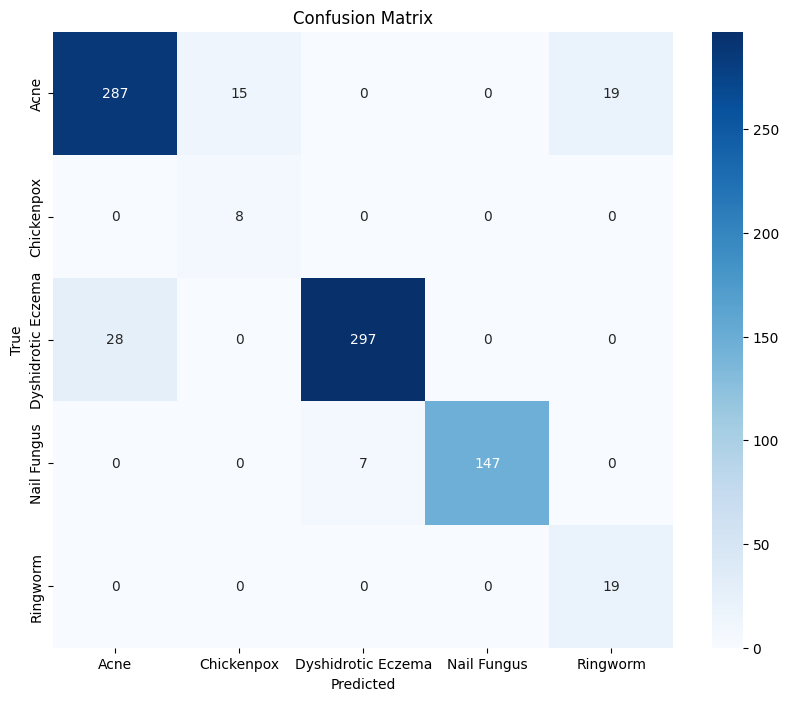

In [ ]:
cm = confusion_matrix(y_true, predict_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()